In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-5).tolist()
        long_ticks = (np.array(long_ticks)-5).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")

        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】

        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = last_trade_price - current_price#【明天開盤 - 今天收盤】

            elif(action == Actions.Sell.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = -(last_trade_price - current_price)#【-(明天開盤 - 今天收盤)】
        
        step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                long_profit_percentage = ((last_trade_price - current_price)/current_price) - self.trade_fee_percent
                self._total_profit += long_profit_percentage
            elif(action == Actions.Sell.value):

                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                short_profit_percentage = ((-(last_trade_price - current_price)) / current_price) - self.trade_fee_percent
                self._total_profit += short_profit_percentage   
                
        step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI
#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
normalizer = Normalizer()#創建標準化函數
df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
                                                      3:'FH',4:'FL',
                                                      5:'UpLine',6:'DownLine',
                                                      7:'RSI',
                                                      8:'K_Value',9:'D_Value',
                                                      10:'DIF',11:'MACD',
                                                      12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df2330

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
0,2000-01-31,77.474449,79.822517,77.083290,79.430984,40.596722,1.680593e+11,2330.TW,0.309921,0.361288,...,0.001713,0.001712,0.340351,0.351078,0.349870,0.011103,0.006873,0.354890,0.319509,0.284129
1,2000-02-01,80.213676,80.213676,78.648293,79.039825,40.396797,1.530819e+11,2330.TW,0.314672,0.366827,...,0.000000,0.001740,0.327941,0.341312,0.350593,0.011484,0.007879,0.363530,0.326493,0.289457
2,2000-02-02,79.039825,79.039825,79.039825,79.039825,40.396797,0.000000e+00,2330.TW,0.319760,0.370711,...,0.000000,0.000000,0.315521,0.333172,0.347261,0.011640,0.008698,0.370338,0.331708,0.293078
3,2000-02-03,79.039825,79.039825,79.039825,79.039825,40.396797,0.000000e+00,2330.TW,0.329770,0.372094,...,0.000000,0.000000,0.344641,0.316836,0.337983,0.011578,0.009300,0.374065,0.335061,0.296056
4,2000-02-04,79.039825,79.039825,79.039825,79.039825,40.396797,0.000000e+00,2330.TW,0.339458,0.376977,...,0.000000,0.000000,0.349164,0.300968,0.328601,0.011512,0.009840,0.380023,0.342048,0.304073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5646,2022-09-08,473.000000,475.000000,472.000000,475.000000,472.278656,2.793155e+07,2330.TW,0.423638,0.453257,...,0.000000,0.000898,0.028192,0.007732,0.010367,-0.005827,-0.002053,0.480573,0.451798,0.423024
5647,2022-09-12,485.000000,491.000000,485.000000,486.500000,483.712769,2.159721e+07,2330.TW,0.423915,0.453553,...,0.004042,0.000000,0.036534,0.018312,0.013020,-0.005704,-0.002784,0.479664,0.450724,0.421784
5648,2022-09-13,495.000000,495.000000,491.000000,493.000000,490.175537,1.650704e+07,2330.TW,0.424165,0.453820,...,0.000000,0.001797,0.037444,0.031278,0.019111,-0.005078,-0.003244,0.477420,0.449642,0.421863
5649,2022-09-14,478.500000,482.500000,476.000000,480.000000,477.250000,2.264571e+07,2330.TW,0.427568,0.448856,...,0.002265,0.002265,0.030653,0.031298,0.023276,-0.005502,-0.003717,0.478336,0.451212,0.424088


# 查找DF的標籤

In [6]:
dfStartDate_Train = df2330[(df2330['index']=='2007-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

1793

In [7]:
dfEndDate_Train = df2330[(df2330['index']=='2022-06-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5596

In [8]:
df2330[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
1793,2007-01-02,66.790359,66.987381,66.297806,66.691849,37.359825,26292533.0,2330.TW,0.298317,0.314018,...,0.000924,0.001847,0.330271,0.375104,0.318968,0.003697,0.003264,0.314696,0.304389,0.294083
1794,2007-01-03,66.790359,67.676956,66.494827,66.987381,37.525368,42463339.0,2330.TW,0.302538,0.320747,...,0.003268,0.001401,0.325475,0.382450,0.342472,0.004142,0.003468,0.319093,0.308001,0.296909
1795,2007-01-04,66.691849,67.085892,66.593338,66.691849,37.359825,22444226.0,2330.TW,0.312725,0.331035,...,0.001927,0.000482,0.283559,0.383284,0.363400,0.004437,0.003751,0.329130,0.317832,0.306534
1796,2007-01-05,66.494827,66.691849,65.509720,65.903763,36.918343,30905222.0,2330.TW,0.326070,0.345162,...,0.001005,0.002010,0.329041,0.355903,0.371239,0.004386,0.004006,0.343108,0.331370,0.319633
1797,2007-01-08,65.115677,65.509720,64.721634,64.820145,36.311314,24350615.0,2330.TW,0.355820,0.376074,...,0.002190,0.000547,0.317538,0.298569,0.369181,0.004038,0.004299,0.373754,0.360966,0.348177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5592,2022-06-24,489.500000,492.500000,485.500000,486.500000,483.712769,27911980.0,2330.TW,0.421797,0.448757,...,0.002609,0.000870,0.009466,0.004935,0.007676,-0.010773,-0.007574,0.491998,0.453649,0.415300
5593,2022-06-27,496.000000,506.000000,495.500000,498.500000,495.644012,37909718.0,2330.TW,0.422116,0.449096,...,0.006528,0.000435,0.021099,0.015926,0.010430,-0.010414,-0.008147,0.491810,0.452621,0.413433
5594,2022-06-28,496.000000,500.000000,496.000000,497.500000,494.649750,15274062.0,2330.TW,0.423326,0.450384,...,0.002182,0.000000,0.024078,0.022380,0.014433,-0.010106,-0.008557,0.490394,0.451758,0.413123
5595,2022-06-29,496.000000,498.500000,491.000000,491.000000,488.186981,30533789.0,2330.TW,0.426897,0.445382,...,0.002201,0.000000,0.027083,0.023429,0.017513,-0.010265,-0.008956,0.488750,0.452533,0.416316


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    signal_features = df.loc[:, ['DIF', 'MACD']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._signal_features

    
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[256, 'lstm', dict(vf=[128], pi=[128])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs, gamma=0.1, learning_rate=0.0000001)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=1000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.00021  |
| fps                | 0        |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 0.162    |
---------------------------------
----------------------------------
| explained_variance | -1.97e-05 |
| fps                | 33        |
| nupdates           | 100       |
| policy_entropy     | 0.693     |
| total_timesteps    | 500       |
| value_loss         | 7.67      |
----------------------------------
---------------------------------
| explained_variance |

---------------------------------
| explained_variance | 6.81e-05 |
| fps                | 68       |
| nupdates           | 1500     |
| policy_entropy     | 0.693    |
| total_timesteps    | 7500     |
| value_loss         | 49.6     |
---------------------------------
---------------------------------
| explained_variance | 3.06e-05 |
| fps                | 68       |
| nupdates           | 1600     |
| policy_entropy     | 0.693    |
| total_timesteps    | 8000     |
| value_loss         | 0.887    |
---------------------------------
---------------------------------
| explained_variance | -0.00016 |
| fps                | 67       |
| nupdates           | 1700     |
| policy_entropy     | 0.693    |
| total_timesteps    | 8500     |
| value_loss         | 0.198    |
---------------------------------
----------------------------------
| explained_variance | -0.000148 |
| fps                | 68        |
| nupdates           | 1800      |
| policy_entropy     | 0.693     |
| total_t

---------------------------------
| explained_variance | 5.66e-06 |
| fps                | 67       |
| nupdates           | 4500     |
| policy_entropy     | 0.693    |
| total_timesteps    | 22500    |
| value_loss         | 237      |
---------------------------------
---------------------------------
| explained_variance | 6.97e-06 |
| fps                | 67       |
| nupdates           | 4600     |
| policy_entropy     | 0.693    |
| total_timesteps    | 23000    |
| value_loss         | 0.537    |
---------------------------------
---------------------------------
| explained_variance | 4.63e-05 |
| fps                | 67       |
| nupdates           | 4700     |
| policy_entropy     | 0.693    |
| total_timesteps    | 23500    |
| value_loss         | 0.37     |
---------------------------------
----------------------------------
| explained_variance | -0.000212 |
| fps                | 68        |
| nupdates           | 4800      |
| policy_entropy     | 0.693     |
| total_t

---------------------------------
| explained_variance | -0.00017 |
| fps                | 69       |
| nupdates           | 7500     |
| policy_entropy     | 0.693    |
| total_timesteps    | 37500    |
| value_loss         | 8.22     |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 69        |
| nupdates           | 7600      |
| policy_entropy     | 0.693     |
| total_timesteps    | 38000     |
| value_loss         | 68.7      |
----------------------------------
----------------------------------
| explained_variance | -0.000185 |
| fps                | 69        |
| nupdates           | 7700      |
| policy_entropy     | 0.693     |
| total_timesteps    | 38500     |
| value_loss         | 6.06      |
----------------------------------
---------------------------------
| explained_variance | 0.000212 |
| fps                | 69       |
| nupdates           | 7800     |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 8.52e-05 |
| fps                | 69       |
| nupdates           | 10500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 52500    |
| value_loss         | 9.75     |
---------------------------------
---------------------------------
| explained_variance | 2.23e-05 |
| fps                | 69       |
| nupdates           | 10600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 53000    |
| value_loss         | 13.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000177 |
| fps                | 69        |
| nupdates           | 10700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 53500     |
| value_loss         | 1.6       |
----------------------------------
---------------------------------
| explained_variance | 1.45e-05 |
| fps                | 69       |
| nupdates           | 10800    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 8.02e-05 |
| fps                | 69       |
| nupdates           | 13500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 67500    |
| value_loss         | 3.32     |
---------------------------------
---------------------------------
| explained_variance | 5.19e-05 |
| fps                | 69       |
| nupdates           | 13600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 68000    |
| value_loss         | 26.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000213 |
| fps                | 69        |
| nupdates           | 13700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 68500     |
| value_loss         | 0.0773    |
----------------------------------
----------------------------------
| explained_variance | -2.01e-05 |
| fps                | 69        |
| nupdates           | 13800     |
| policy_entropy     | 0.693     |
|

----------------------------------
| explained_variance | -1.18e-05 |
| fps                | 70        |
| nupdates           | 16500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 82500     |
| value_loss         | 3.91      |
----------------------------------
---------------------------------
| explained_variance | 8.17e-06 |
| fps                | 70       |
| nupdates           | 16600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 83000    |
| value_loss         | 7.65     |
---------------------------------
----------------------------------
| explained_variance | -2.54e-05 |
| fps                | 70        |
| nupdates           | 16700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 83500     |
| value_loss         | 46.1      |
----------------------------------
---------------------------------
| explained_variance | 6.91e-05 |
| fps                | 70       |
| nupdates           | 16800    |
| policy_entropy     | 0.693    

----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 70        |
| nupdates           | 19500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 97500     |
| value_loss         | 8.2       |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 70        |
| nupdates           | 19600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 98000     |
| value_loss         | 9.33      |
----------------------------------
----------------------------------
| explained_variance | -6.08e-06 |
| fps                | 70        |
| nupdates           | 19700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 98500     |
| value_loss         | 13.2      |
----------------------------------
----------------------------------
| explained_variance | -0.000145 |
| fps                | 70        |
| nupdates           | 19800     |
| policy_entropy    

----------------------------------
| explained_variance | -2.31e-05 |
| fps                | 70        |
| nupdates           | 22500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 112500    |
| value_loss         | 2.06      |
----------------------------------
---------------------------------
| explained_variance | 2.83e-05 |
| fps                | 70       |
| nupdates           | 22600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 113000   |
| value_loss         | 1.94     |
---------------------------------
---------------------------------
| explained_variance | -4.2e-05 |
| fps                | 70       |
| nupdates           | 22700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 113500   |
| value_loss         | 3.59     |
---------------------------------
---------------------------------
| explained_variance | 4.11e-06 |
| fps                | 70       |
| nupdates           | 22800    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 6.23e-05 |
| fps                | 70       |
| nupdates           | 25500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 127500   |
| value_loss         | 0.76     |
---------------------------------
---------------------------------
| explained_variance | -2.5e-05 |
| fps                | 70       |
| nupdates           | 25600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 128000   |
| value_loss         | 1.02     |
---------------------------------
---------------------------------
| explained_variance | 1.51e-05 |
| fps                | 70       |
| nupdates           | 25700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 128500   |
| value_loss         | 4.48     |
---------------------------------
----------------------------------
| explained_variance | -1.69e-05 |
| fps                | 70        |
| nupdates           | 25800     |
| policy_entropy     | 0.693     |
| total_t

---------------------------------
| explained_variance | 3.28e-05 |
| fps                | 70       |
| nupdates           | 28500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 142500   |
| value_loss         | 2.91     |
---------------------------------
---------------------------------
| explained_variance | 5.58e-05 |
| fps                | 70       |
| nupdates           | 28600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 143000   |
| value_loss         | 5.47     |
---------------------------------
----------------------------------
| explained_variance | -6.75e-05 |
| fps                | 70        |
| nupdates           | 28700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 143500    |
| value_loss         | 7.73      |
----------------------------------
---------------------------------
| explained_variance | -9.8e-05 |
| fps                | 70       |
| nupdates           | 28800    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.000266 |
| fps                | 70       |
| nupdates           | 31500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 157500   |
| value_loss         | 0.511    |
---------------------------------
----------------------------------
| explained_variance | -0.000114 |
| fps                | 70        |
| nupdates           | 31600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 158000    |
| value_loss         | 1.17      |
----------------------------------
---------------------------------
| explained_variance | -7.2e-05 |
| fps                | 70       |
| nupdates           | 31700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 158500   |
| value_loss         | 1.49     |
---------------------------------
---------------------------------
| explained_variance | 2.72e-05 |
| fps                | 70       |
| nupdates           | 31800    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -1.63e-05 |
| fps                | 70        |
| nupdates           | 34500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 172500    |
| value_loss         | 1.34      |
----------------------------------
---------------------------------
| explained_variance | 0.000392 |
| fps                | 70       |
| nupdates           | 34600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 173000   |
| value_loss         | 0.757    |
---------------------------------
---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 70       |
| nupdates           | 34700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 173500   |
| value_loss         | 2.15     |
---------------------------------
---------------------------------
| explained_variance | 0.000161 |
| fps                | 70       |
| nupdates           | 34800    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -1.49e-05 |
| fps                | 70        |
| nupdates           | 37500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 187500    |
| value_loss         | 0.339     |
----------------------------------
---------------------------------
| explained_variance | 0.000138 |
| fps                | 70       |
| nupdates           | 37600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 188000   |
| value_loss         | 2.62     |
---------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 70       |
| nupdates           | 37700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 188500   |
| value_loss         | 3.35     |
---------------------------------
---------------------------------
| explained_variance | 9.32e-05 |
| fps                | 70       |
| nupdates           | 37800    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -0.000369 |
| fps                | 70        |
| nupdates           | 40500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 202500    |
| value_loss         | 0.042     |
----------------------------------
---------------------------------
| explained_variance | 0.000141 |
| fps                | 70       |
| nupdates           | 40600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 203000   |
| value_loss         | 0.425    |
---------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 70        |
| nupdates           | 40700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 203500    |
| value_loss         | 0.432     |
----------------------------------
---------------------------------
| explained_variance | 8.8e-05  |
| fps                | 70       |
| nupdates           | 40800    |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 0.000415 |
| fps                | 70       |
| nupdates           | 43500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 217500   |
| value_loss         | 0.0965   |
---------------------------------
----------------------------------
| explained_variance | -0.000204 |
| fps                | 70        |
| nupdates           | 43600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 218000    |
| value_loss         | 1.51      |
----------------------------------
---------------------------------
| explained_variance | 5.9e-06  |
| fps                | 70       |
| nupdates           | 43700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 218500   |
| value_loss         | 0.936    |
---------------------------------
----------------------------------
| explained_variance | -3.53e-05 |
| fps                | 70        |
| nupdates           | 43800     |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 3.12e-05 |
| fps                | 70       |
| nupdates           | 46500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 232500   |
| value_loss         | 9.66     |
---------------------------------
----------------------------------
| explained_variance | -0.000319 |
| fps                | 70        |
| nupdates           | 46600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 233000    |
| value_loss         | 0.09      |
----------------------------------
---------------------------------
| explained_variance | -0.00112 |
| fps                | 70       |
| nupdates           | 46700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 233500   |
| value_loss         | 0.143    |
---------------------------------
---------------------------------
| explained_variance | 2.84e-05 |
| fps                | 70       |
| nupdates           | 46800    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -0.000121 |
| fps                | 70        |
| nupdates           | 49500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 247500    |
| value_loss         | 0.0685    |
----------------------------------
----------------------------------
| explained_variance | -5.83e-05 |
| fps                | 70        |
| nupdates           | 49600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 248000    |
| value_loss         | 0.0206    |
----------------------------------
---------------------------------
| explained_variance | 0.000185 |
| fps                | 70       |
| nupdates           | 49700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 248500   |
| value_loss         | 0.17     |
---------------------------------
---------------------------------
| explained_variance | 8.72e-05 |
| fps                | 70       |
| nupdates           | 49800    |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 0.000175 |
| fps                | 70       |
| nupdates           | 52500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 262500   |
| value_loss         | 0.367    |
---------------------------------
---------------------------------
| explained_variance | 0.000104 |
| fps                | 70       |
| nupdates           | 52600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 263000   |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00061  |
| fps                | 70       |
| nupdates           | 52700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 263500   |
| value_loss         | 0.642    |
---------------------------------
----------------------------------
| explained_variance | -2.41e-05 |
| fps                | 70        |
| nupdates           | 52800     |
| policy_entropy     | 0.693     |
| total_t

---------------------------------
| explained_variance | 2.11e-05 |
| fps                | 70       |
| nupdates           | 55500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 277500   |
| value_loss         | 15.5     |
---------------------------------
---------------------------------
| explained_variance | 5.37e-05 |
| fps                | 70       |
| nupdates           | 55600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 278000   |
| value_loss         | 0.444    |
---------------------------------
----------------------------------
| explained_variance | -3.71e-05 |
| fps                | 70        |
| nupdates           | 55700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 278500    |
| value_loss         | 0.214     |
----------------------------------
---------------------------------
| explained_variance | 0.000324 |
| fps                | 70       |
| nupdates           | 55800    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 1.15e-05 |
| fps                | 70       |
| nupdates           | 58500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 292500   |
| value_loss         | 8.06     |
---------------------------------
---------------------------------
| explained_variance | 0.000192 |
| fps                | 70       |
| nupdates           | 58600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 293000   |
| value_loss         | 0.27     |
---------------------------------
----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 70        |
| nupdates           | 58700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 293500    |
| value_loss         | 6.05      |
----------------------------------
---------------------------------
| explained_variance | 0.000221 |
| fps                | 70       |
| nupdates           | 58800    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -5.76e-05 |
| fps                | 70        |
| nupdates           | 61500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 307500    |
| value_loss         | 4.99      |
----------------------------------
---------------------------------
| explained_variance | 1.87e-05 |
| fps                | 70       |
| nupdates           | 61600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 308000   |
| value_loss         | 9.37     |
---------------------------------
----------------------------------
| explained_variance | -0.000247 |
| fps                | 70        |
| nupdates           | 61700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 308500    |
| value_loss         | 3.4       |
----------------------------------
----------------------------------
| explained_variance | -0.000148 |
| fps                | 70        |
| nupdates           | 61800     |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 4.39e-05 |
| fps                | 69       |
| nupdates           | 64500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 322500   |
| value_loss         | 7.67     |
---------------------------------
----------------------------------
| explained_variance | -1.14e-05 |
| fps                | 69        |
| nupdates           | 64600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 323000    |
| value_loss         | 100       |
----------------------------------
---------------------------------
| explained_variance | 2.99e-05 |
| fps                | 69       |
| nupdates           | 64700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 323500   |
| value_loss         | 0.95     |
---------------------------------
---------------------------------
| explained_variance | 5.07e-05 |
| fps                | 69       |
| nupdates           | 64800    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.000236 |
| fps                | 69       |
| nupdates           | 67500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 337500   |
| value_loss         | 5.57     |
---------------------------------
---------------------------------
| explained_variance | 2.81e-05 |
| fps                | 69       |
| nupdates           | 67600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 338000   |
| value_loss         | 99.4     |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 69        |
| nupdates           | 67700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 338500    |
| value_loss         | 38.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000136 |
| fps                | 69        |
| nupdates           | 67800     |
| policy_entropy     | 0.693     |
|

----------------------------------
| explained_variance | -2.78e-05 |
| fps                | 69        |
| nupdates           | 70500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 352500    |
| value_loss         | 0.523     |
----------------------------------
----------------------------------
| explained_variance | -8.14e-05 |
| fps                | 69        |
| nupdates           | 70600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 353000    |
| value_loss         | 7.53      |
----------------------------------
---------------------------------
| explained_variance | 5.2e-05  |
| fps                | 69       |
| nupdates           | 70700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 353500   |
| value_loss         | 45.1     |
---------------------------------
---------------------------------
| explained_variance | 0.000308 |
| fps                | 69       |
| nupdates           | 70800    |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 69       |
| nupdates           | 73500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 367500   |
| value_loss         | 1.62     |
---------------------------------
---------------------------------
| explained_variance | 7.75e-05 |
| fps                | 69       |
| nupdates           | 73600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 368000   |
| value_loss         | 0.714    |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 69       |
| nupdates           | 73700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 368500   |
| value_loss         | 7.5      |
---------------------------------
---------------------------------
| explained_variance | 0.000101 |
| fps                | 69       |
| nupdates           | 73800    |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | 0.000211 |
| fps                | 69       |
| nupdates           | 76500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 382500   |
| value_loss         | 0.642    |
---------------------------------
----------------------------------
| explained_variance | -6.74e-05 |
| fps                | 69        |
| nupdates           | 76600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 383000    |
| value_loss         | 1.85      |
----------------------------------
---------------------------------
| explained_variance | 2.93e-05 |
| fps                | 69       |
| nupdates           | 76700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 383500   |
| value_loss         | 13.9     |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 69       |
| nupdates           | 76800    |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -0.000154 |
| fps                | 69        |
| nupdates           | 79500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 397500    |
| value_loss         | 0.382     |
----------------------------------
----------------------------------
| explained_variance | -8.21e-05 |
| fps                | 69        |
| nupdates           | 79600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 398000    |
| value_loss         | 1.68      |
----------------------------------
----------------------------------
| explained_variance | -0.000173 |
| fps                | 69        |
| nupdates           | 79700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 398500    |
| value_loss         | 2.95      |
----------------------------------
---------------------------------
| explained_variance | 8.11e-05 |
| fps                | 69       |
| nupdates           | 79800    |
| policy_entropy     | 0

----------------------------------
| explained_variance | -3.43e-05 |
| fps                | 69        |
| nupdates           | 82500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 412500    |
| value_loss         | 2.67      |
----------------------------------
---------------------------------
| explained_variance | 7.26e-05 |
| fps                | 69       |
| nupdates           | 82600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 413000   |
| value_loss         | 2.16     |
---------------------------------
---------------------------------
| explained_variance | 0.000145 |
| fps                | 69       |
| nupdates           | 82700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 413500   |
| value_loss         | 2.64     |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 69       |
| nupdates           | 82800    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 9.05e-05 |
| fps                | 69       |
| nupdates           | 85500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 427500   |
| value_loss         | 0.038    |
---------------------------------
----------------------------------
| explained_variance | -2.12e-05 |
| fps                | 69        |
| nupdates           | 85600     |
| policy_entropy     | 0.693     |
| total_timesteps    | 428000    |
| value_loss         | 1.63      |
----------------------------------
----------------------------------
| explained_variance | -2.04e-05 |
| fps                | 69        |
| nupdates           | 85700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 428500    |
| value_loss         | 4.65      |
----------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 69        |
| nupdates           | 85800     |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 6.66e-05 |
| fps                | 69       |
| nupdates           | 88500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 442500   |
| value_loss         | 1.07     |
---------------------------------
---------------------------------
| explained_variance | 0.000132 |
| fps                | 69       |
| nupdates           | 88600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 443000   |
| value_loss         | 0.754    |
---------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 69       |
| nupdates           | 88700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 443500   |
| value_loss         | 8.71     |
---------------------------------
---------------------------------
| explained_variance | 0.000241 |
| fps                | 69       |
| nupdates           | 88800    |
| policy_entropy     | 0.693    |
| total_timest

----------------------------------
| explained_variance | -3.86e-05 |
| fps                | 69        |
| nupdates           | 91500     |
| policy_entropy     | 0.693     |
| total_timesteps    | 457500    |
| value_loss         | 0.0978    |
----------------------------------
---------------------------------
| explained_variance | -9.2e-05 |
| fps                | 69       |
| nupdates           | 91600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 458000   |
| value_loss         | 1.43     |
---------------------------------
---------------------------------
| explained_variance | 0.000162 |
| fps                | 69       |
| nupdates           | 91700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 458500   |
| value_loss         | 0.868    |
---------------------------------
----------------------------------
| explained_variance | -8.39e-05 |
| fps                | 69        |
| nupdates           | 91800     |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 0.000311 |
| fps                | 69       |
| nupdates           | 94500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 472500   |
| value_loss         | 0.207    |
---------------------------------
---------------------------------
| explained_variance | 6.72e-05 |
| fps                | 69       |
| nupdates           | 94600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 473000   |
| value_loss         | 0.793    |
---------------------------------
----------------------------------
| explained_variance | -3.55e-05 |
| fps                | 69        |
| nupdates           | 94700     |
| policy_entropy     | 0.693     |
| total_timesteps    | 473500    |
| value_loss         | 2.11      |
----------------------------------
---------------------------------
| explained_variance | 3.84e-05 |
| fps                | 69       |
| nupdates           | 94800    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 2.08e-05 |
| fps                | 69       |
| nupdates           | 97500    |
| policy_entropy     | 0.693    |
| total_timesteps    | 487500   |
| value_loss         | 9.48     |
---------------------------------
---------------------------------
| explained_variance | 0.000182 |
| fps                | 69       |
| nupdates           | 97600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 488000   |
| value_loss         | 0.192    |
---------------------------------
---------------------------------
| explained_variance | 0.000286 |
| fps                | 69       |
| nupdates           | 97700    |
| policy_entropy     | 0.693    |
| total_timesteps    | 488500   |
| value_loss         | 1.78     |
---------------------------------
---------------------------------
| explained_variance | 0.000623 |
| fps                | 69       |
| nupdates           | 97800    |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | 0.000249 |
| fps                | 69       |
| nupdates           | 100500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 502500   |
| value_loss         | 0.409    |
---------------------------------
---------------------------------
| explained_variance | 0.000205 |
| fps                | 69       |
| nupdates           | 100600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 503000   |
| value_loss         | 0.137    |
---------------------------------
----------------------------------
| explained_variance | -2.93e-05 |
| fps                | 69        |
| nupdates           | 100700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 503500    |
| value_loss         | 1.22      |
----------------------------------
---------------------------------
| explained_variance | 0.000347 |
| fps                | 69       |
| nupdates           | 100800   |
| policy_entropy     | 0.693    |
| tota

----------------------------------
| explained_variance | -8.05e-05 |
| fps                | 69        |
| nupdates           | 103500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 517500    |
| value_loss         | 0.761     |
----------------------------------
---------------------------------
| explained_variance | -0.00011 |
| fps                | 69       |
| nupdates           | 103600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 518000   |
| value_loss         | 0.14     |
---------------------------------
----------------------------------
| explained_variance | -0.000246 |
| fps                | 69        |
| nupdates           | 103700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 518500    |
| value_loss         | 0.405     |
----------------------------------
----------------------------------
| explained_variance | -0.000601 |
| fps                | 69        |
| nupdates           | 103800    |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 1.62e-05 |
| fps                | 69       |
| nupdates           | 106500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 532500   |
| value_loss         | 68       |
---------------------------------
----------------------------------
| explained_variance | -9.42e-05 |
| fps                | 69        |
| nupdates           | 106600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 533000    |
| value_loss         | 9.53      |
----------------------------------
---------------------------------
| explained_variance | 1.13e-05 |
| fps                | 69       |
| nupdates           | 106700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 533500   |
| value_loss         | 0.125    |
---------------------------------
----------------------------------
| explained_variance | -0.000125 |
| fps                | 69        |
| nupdates           | 106800    |
| policy_entropy     | 0.693     |
|

----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 69        |
| nupdates           | 109500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 547500    |
| value_loss         | 132       |
----------------------------------
---------------------------------
| explained_variance | 0.000477 |
| fps                | 69       |
| nupdates           | 109600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 548000   |
| value_loss         | 0.248    |
---------------------------------
----------------------------------
| explained_variance | -9.66e-05 |
| fps                | 69        |
| nupdates           | 109700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 548500    |
| value_loss         | 0.3       |
----------------------------------
---------------------------------
| explained_variance | 6.38e-06 |
| fps                | 69       |
| nupdates           | 109800   |
| policy_entropy     | 0.693    

----------------------------------
| explained_variance | -0.000121 |
| fps                | 69        |
| nupdates           | 112500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 562500    |
| value_loss         | 7.22      |
----------------------------------
----------------------------------
| explained_variance | -0.000251 |
| fps                | 69        |
| nupdates           | 112600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 563000    |
| value_loss         | 0.828     |
----------------------------------
----------------------------------
| explained_variance | -0.000103 |
| fps                | 69        |
| nupdates           | 112700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 563500    |
| value_loss         | 6.93      |
----------------------------------
----------------------------------
| explained_variance | -1.92e-05 |
| fps                | 69        |
| nupdates           | 112800    |
| policy_entropy    

----------------------------------
| explained_variance | -7.14e-05 |
| fps                | 69        |
| nupdates           | 115500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 577500    |
| value_loss         | 4.72      |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 69        |
| nupdates           | 115600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 578000    |
| value_loss         | 64.1      |
----------------------------------
----------------------------------
| explained_variance | -0.000117 |
| fps                | 69        |
| nupdates           | 115700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 578500    |
| value_loss         | 0.988     |
----------------------------------
----------------------------------
| explained_variance | -0.000128 |
| fps                | 69        |
| nupdates           | 115800    |
| policy_entropy    

---------------------------------
| explained_variance | 8.84e-05 |
| fps                | 69       |
| nupdates           | 118500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 592500   |
| value_loss         | 7.41     |
---------------------------------
---------------------------------
| explained_variance | 1.23e-05 |
| fps                | 69       |
| nupdates           | 118600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 593000   |
| value_loss         | 19.8     |
---------------------------------
---------------------------------
| explained_variance | 0.000173 |
| fps                | 69       |
| nupdates           | 118700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 593500   |
| value_loss         | 0.252    |
---------------------------------
----------------------------------
| explained_variance | -8.99e-05 |
| fps                | 69        |
| nupdates           | 118800    |
| policy_entropy     | 0.693     |
| total_t

----------------------------------
| explained_variance | -0.000291 |
| fps                | 69        |
| nupdates           | 121500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 607500    |
| value_loss         | 5.28      |
----------------------------------
---------------------------------
| explained_variance | -5.5e-05 |
| fps                | 69       |
| nupdates           | 121600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 608000   |
| value_loss         | 1.46     |
---------------------------------
----------------------------------
| explained_variance | -1.29e-05 |
| fps                | 69        |
| nupdates           | 121700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 608500    |
| value_loss         | 9.65      |
----------------------------------
---------------------------------
| explained_variance | 0.000147 |
| fps                | 69       |
| nupdates           | 121800   |
| policy_entropy     | 0.693    

----------------------------------
| explained_variance | -7.38e-05 |
| fps                | 69        |
| nupdates           | 124500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 622500    |
| value_loss         | 0.373     |
----------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 69        |
| nupdates           | 124600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 623000    |
| value_loss         | 2.53      |
----------------------------------
----------------------------------
| explained_variance | -1.12e-05 |
| fps                | 69        |
| nupdates           | 124700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 623500    |
| value_loss         | 84.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000465 |
| fps                | 69        |
| nupdates           | 124800    |
| policy_entropy    

---------------------------------
| explained_variance | 4.89e-05 |
| fps                | 69       |
| nupdates           | 127500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 637500   |
| value_loss         | 0.687    |
---------------------------------
----------------------------------
| explained_variance | -9.95e-05 |
| fps                | 69        |
| nupdates           | 127600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 638000    |
| value_loss         | 5.81      |
----------------------------------
----------------------------------
| explained_variance | -1.04e-05 |
| fps                | 69        |
| nupdates           | 127700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 638500    |
| value_loss         | 11.4      |
----------------------------------
---------------------------------
| explained_variance | 2e-05    |
| fps                | 69       |
| nupdates           | 127800   |
| policy_entropy     | 0.693    

----------------------------------
| explained_variance | -5.97e-05 |
| fps                | 69        |
| nupdates           | 130500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 652500    |
| value_loss         | 0.619     |
----------------------------------
---------------------------------
| explained_variance | 6.83e-05 |
| fps                | 69       |
| nupdates           | 130600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 653000   |
| value_loss         | 1.03     |
---------------------------------
---------------------------------
| explained_variance | 7.69e-06 |
| fps                | 69       |
| nupdates           | 130700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 653500   |
| value_loss         | 16       |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 69        |
| nupdates           | 130800    |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 69       |
| nupdates           | 133500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 667500   |
| value_loss         | 1.62     |
---------------------------------
---------------------------------
| explained_variance | 8.22e-05 |
| fps                | 69       |
| nupdates           | 133600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 668000   |
| value_loss         | 1.8      |
---------------------------------
----------------------------------
| explained_variance | -7.99e-05 |
| fps                | 69        |
| nupdates           | 133700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 668500    |
| value_loss         | 0.936     |
----------------------------------
----------------------------------
| explained_variance | -2.57e-05 |
| fps                | 69        |
| nupdates           | 133800    |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 0.000239 |
| fps                | 69       |
| nupdates           | 136500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 682500   |
| value_loss         | 0.667    |
---------------------------------
---------------------------------
| explained_variance | 6.35e-05 |
| fps                | 69       |
| nupdates           | 136600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 683000   |
| value_loss         | 1.27     |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 69       |
| nupdates           | 136700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 683500   |
| value_loss         | 6.79     |
---------------------------------
---------------------------------
| explained_variance | 3.76e-05 |
| fps                | 69       |
| nupdates           | 136800   |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | 4.58e-05 |
| fps                | 69       |
| nupdates           | 139500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 697500   |
| value_loss         | 0.675    |
---------------------------------
----------------------------------
| explained_variance | -3.78e-05 |
| fps                | 69        |
| nupdates           | 139600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 698000    |
| value_loss         | 0.1       |
----------------------------------
----------------------------------
| explained_variance | -4.21e-05 |
| fps                | 69        |
| nupdates           | 139700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 698500    |
| value_loss         | 2.82      |
----------------------------------
---------------------------------
| explained_variance | 0.000121 |
| fps                | 69       |
| nupdates           | 139800   |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 0.000291 |
| fps                | 69       |
| nupdates           | 142500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 712500   |
| value_loss         | 0.272    |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 69        |
| nupdates           | 142600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 713000    |
| value_loss         | 0.797     |
----------------------------------
----------------------------------
| explained_variance | -0.000122 |
| fps                | 69        |
| nupdates           | 142700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 713500    |
| value_loss         | 1.18      |
----------------------------------
----------------------------------
| explained_variance | -2.55e-05 |
| fps                | 69        |
| nupdates           | 142800    |
| policy_entropy     | 0.693

----------------------------------
| explained_variance | -0.000276 |
| fps                | 69        |
| nupdates           | 145500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 727500    |
| value_loss         | 0.0837    |
----------------------------------
----------------------------------
| explained_variance | -0.000164 |
| fps                | 69        |
| nupdates           | 145600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 728000    |
| value_loss         | 0.0728    |
----------------------------------
----------------------------------
| explained_variance | -0.000215 |
| fps                | 69        |
| nupdates           | 145700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 728500    |
| value_loss         | 0.731     |
----------------------------------
----------------------------------
| explained_variance | -3.92e-05 |
| fps                | 69        |
| nupdates           | 145800    |
| policy_entropy    

---------------------------------
| explained_variance | 2.78e-05 |
| fps                | 69       |
| nupdates           | 148500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 742500   |
| value_loss         | 0.428    |
---------------------------------
----------------------------------
| explained_variance | -0.000175 |
| fps                | 69        |
| nupdates           | 148600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 743000    |
| value_loss         | 0.216     |
----------------------------------
---------------------------------
| explained_variance | -0.00012 |
| fps                | 69       |
| nupdates           | 148700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 743500   |
| value_loss         | 0.191    |
---------------------------------
----------------------------------
| explained_variance | -0.000121 |
| fps                | 69        |
| nupdates           | 148800    |
| policy_entropy     | 0.693     |
|

---------------------------------
| explained_variance | 3.55e-05 |
| fps                | 69       |
| nupdates           | 151500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 757500   |
| value_loss         | 8.51     |
---------------------------------
---------------------------------
| explained_variance | 0.000772 |
| fps                | 69       |
| nupdates           | 151600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 758000   |
| value_loss         | 0.128    |
---------------------------------
----------------------------------
| explained_variance | -4.49e-05 |
| fps                | 69        |
| nupdates           | 151700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 758500    |
| value_loss         | 1.27      |
----------------------------------
---------------------------------
| explained_variance | 4.73e-05 |
| fps                | 69       |
| nupdates           | 151800   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 69       |
| nupdates           | 154500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 772500   |
| value_loss         | 1.21     |
---------------------------------
---------------------------------
| explained_variance | 0.000254 |
| fps                | 69       |
| nupdates           | 154600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 773000   |
| value_loss         | 0.2      |
---------------------------------
----------------------------------
| explained_variance | -5.82e-05 |
| fps                | 69        |
| nupdates           | 154700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 773500    |
| value_loss         | 1.96      |
----------------------------------
---------------------------------
| explained_variance | 2.11e-05 |
| fps                | 69       |
| nupdates           | 154800   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.000121 |
| fps                | 69       |
| nupdates           | 157500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 787500   |
| value_loss         | 0.311    |
---------------------------------
---------------------------------
| explained_variance | 6.21e-05 |
| fps                | 69       |
| nupdates           | 157600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 788000   |
| value_loss         | 12.9     |
---------------------------------
----------------------------------
| explained_variance | -4.18e-05 |
| fps                | 69        |
| nupdates           | 157700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 788500    |
| value_loss         | 0.242     |
----------------------------------
---------------------------------
| explained_variance | 0.000279 |
| fps                | 69       |
| nupdates           | 157800   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 69       |
| nupdates           | 160500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 802500   |
| value_loss         | 17.1     |
---------------------------------
---------------------------------
| explained_variance | 0.000112 |
| fps                | 69       |
| nupdates           | 160600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 803000   |
| value_loss         | 0.645    |
---------------------------------
----------------------------------
| explained_variance | -0.000137 |
| fps                | 69        |
| nupdates           | 160700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 803500    |
| value_loss         | 0.183     |
----------------------------------
----------------------------------
| explained_variance | -7.21e-05 |
| fps                | 69        |
| nupdates           | 160800    |
| policy_entropy     | 0.693     |
|

----------------------------------
| explained_variance | -0.000165 |
| fps                | 69        |
| nupdates           | 163500    |
| policy_entropy     | 0.693     |
| total_timesteps    | 817500    |
| value_loss         | 0.654     |
----------------------------------
----------------------------------
| explained_variance | -0.000156 |
| fps                | 69        |
| nupdates           | 163600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 818000    |
| value_loss         | 0.504     |
----------------------------------
---------------------------------
| explained_variance | 0.000135 |
| fps                | 69       |
| nupdates           | 163700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 818500   |
| value_loss         | 0.189    |
---------------------------------
----------------------------------
| explained_variance | -5.15e-05 |
| fps                | 69        |
| nupdates           | 163800    |
| policy_entropy     | 0.693

---------------------------------
| explained_variance | 1.56e-05 |
| fps                | 69       |
| nupdates           | 166500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 832500   |
| value_loss         | 13.9     |
---------------------------------
---------------------------------
| explained_variance | 1.89e-05 |
| fps                | 69       |
| nupdates           | 166600   |
| policy_entropy     | 0.693    |
| total_timesteps    | 833000   |
| value_loss         | 163      |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 69       |
| nupdates           | 166700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 833500   |
| value_loss         | 4.06     |
---------------------------------
---------------------------------
| explained_variance | 0.000138 |
| fps                | 69       |
| nupdates           | 166800   |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | 5.14e-05 |
| fps                | 69       |
| nupdates           | 169500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 847500   |
| value_loss         | 7.48     |
---------------------------------
----------------------------------
| explained_variance | -2.87e-05 |
| fps                | 69        |
| nupdates           | 169600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 848000    |
| value_loss         | 13.5      |
----------------------------------
----------------------------------
| explained_variance | -6.69e-05 |
| fps                | 69        |
| nupdates           | 169700    |
| policy_entropy     | 0.693     |
| total_timesteps    | 848500    |
| value_loss         | 0.754     |
----------------------------------
---------------------------------
| explained_variance | 0.000502 |
| fps                | 69       |
| nupdates           | 169800   |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 8.94e-06 |
| fps                | 69       |
| nupdates           | 172500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 862500   |
| value_loss         | 1.95     |
---------------------------------
----------------------------------
| explained_variance | -5.58e-05 |
| fps                | 69        |
| nupdates           | 172600    |
| policy_entropy     | 0.693     |
| total_timesteps    | 863000    |
| value_loss         | 3.01      |
----------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 69       |
| nupdates           | 172700   |
| policy_entropy     | 0.693    |
| total_timesteps    | 863500   |
| value_loss         | 25.9     |
---------------------------------
---------------------------------
| explained_variance | 0.000101 |
| fps                | 69       |
| nupdates           | 172800   |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 0.000123 |
| fps                | 69       |
| nupdates           | 175500   |
| policy_entropy     | 0.692    |
| total_timesteps    | 877500   |
| value_loss         | 1.48     |
---------------------------------
---------------------------------
| explained_variance | 2.71e-05 |
| fps                | 69       |
| nupdates           | 175600   |
| policy_entropy     | 0.692    |
| total_timesteps    | 878000   |
| value_loss         | 3.17     |
---------------------------------
---------------------------------
| explained_variance | 1.57e-05 |
| fps                | 69       |
| nupdates           | 175700   |
| policy_entropy     | 0.692    |
| total_timesteps    | 878500   |
| value_loss         | 17       |
---------------------------------
----------------------------------
| explained_variance | -0.000635 |
| fps                | 69        |
| nupdates           | 175800    |
| policy_entropy     | 0.692     |
| total_t

----------------------------------
| explained_variance | -1.35e-05 |
| fps                | 69        |
| nupdates           | 178500    |
| policy_entropy     | 0.692     |
| total_timesteps    | 892500    |
| value_loss         | 2.26      |
----------------------------------
----------------------------------
| explained_variance | -2.92e-05 |
| fps                | 69        |
| nupdates           | 178600    |
| policy_entropy     | 0.692     |
| total_timesteps    | 893000    |
| value_loss         | 9.94      |
----------------------------------
---------------------------------
| explained_variance | 1.23e-05 |
| fps                | 69       |
| nupdates           | 178700   |
| policy_entropy     | 0.692    |
| total_timesteps    | 893500   |
| value_loss         | 31.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000563 |
| fps                | 69        |
| nupdates           | 178800    |
| policy_entropy     | 0.692

----------------------------------
| explained_variance | -8.86e-05 |
| fps                | 69        |
| nupdates           | 181500    |
| policy_entropy     | 0.692     |
| total_timesteps    | 907500    |
| value_loss         | 3.71      |
----------------------------------
---------------------------------
| explained_variance | 3.08e-05 |
| fps                | 69       |
| nupdates           | 181600   |
| policy_entropy     | 0.692    |
| total_timesteps    | 908000   |
| value_loss         | 2.73     |
---------------------------------
----------------------------------
| explained_variance | -5.54e-05 |
| fps                | 69        |
| nupdates           | 181700    |
| policy_entropy     | 0.692     |
| total_timesteps    | 908500    |
| value_loss         | 6.16      |
----------------------------------
----------------------------------
| explained_variance | -1.73e-05 |
| fps                | 69        |
| nupdates           | 181800    |
| policy_entropy     | 0.692

----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 69        |
| nupdates           | 184500    |
| policy_entropy     | 0.692     |
| total_timesteps    | 922500    |
| value_loss         | 1.87      |
----------------------------------
----------------------------------
| explained_variance | -3.64e-05 |
| fps                | 69        |
| nupdates           | 184600    |
| policy_entropy     | 0.692     |
| total_timesteps    | 923000    |
| value_loss         | 1.48      |
----------------------------------
---------------------------------
| explained_variance | 4.94e-05 |
| fps                | 69       |
| nupdates           | 184700   |
| policy_entropy     | 0.692    |
| total_timesteps    | 923500   |
| value_loss         | 6.51     |
---------------------------------
---------------------------------
| explained_variance | 3.3e-05  |
| fps                | 69       |
| nupdates           | 184800   |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -0.000127 |
| fps                | 69        |
| nupdates           | 187500    |
| policy_entropy     | 0.692     |
| total_timesteps    | 937500    |
| value_loss         | 0.566     |
----------------------------------
----------------------------------
| explained_variance | -8.23e-06 |
| fps                | 69        |
| nupdates           | 187600    |
| policy_entropy     | 0.692     |
| total_timesteps    | 938000    |
| value_loss         | 5.03      |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 69        |
| nupdates           | 187700    |
| policy_entropy     | 0.692     |
| total_timesteps    | 938500    |
| value_loss         | 5.69      |
----------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 69        |
| nupdates           | 187800    |
| policy_entropy    

---------------------------------
| explained_variance | -9.7e-05 |
| fps                | 69       |
| nupdates           | 190500   |
| policy_entropy     | 0.692    |
| total_timesteps    | 952500   |
| value_loss         | 1.44     |
---------------------------------
---------------------------------
| explained_variance | 5.3e-06  |
| fps                | 69       |
| nupdates           | 190600   |
| policy_entropy     | 0.692    |
| total_timesteps    | 953000   |
| value_loss         | 1.94     |
---------------------------------
---------------------------------
| explained_variance | 4.05e-05 |
| fps                | 69       |
| nupdates           | 190700   |
| policy_entropy     | 0.692    |
| total_timesteps    | 953500   |
| value_loss         | 0.48     |
---------------------------------
----------------------------------
| explained_variance | -4.43e-05 |
| fps                | 69        |
| nupdates           | 190800    |
| policy_entropy     | 0.692     |
| total_t

----------------------------------
| explained_variance | -2.47e-05 |
| fps                | 70        |
| nupdates           | 193500    |
| policy_entropy     | 0.692     |
| total_timesteps    | 967500    |
| value_loss         | 0.308     |
----------------------------------
---------------------------------
| explained_variance | 2.1e-05  |
| fps                | 70       |
| nupdates           | 193600   |
| policy_entropy     | 0.692    |
| total_timesteps    | 968000   |
| value_loss         | 2.55     |
---------------------------------
----------------------------------
| explained_variance | -1.01e-05 |
| fps                | 70        |
| nupdates           | 193700    |
| policy_entropy     | 0.692     |
| total_timesteps    | 968500    |
| value_loss         | 2.55      |
----------------------------------
---------------------------------
| explained_variance | 1.03e-05 |
| fps                | 70       |
| nupdates           | 193800   |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -8.94e-05 |
| fps                | 70        |
| nupdates           | 196500    |
| policy_entropy     | 0.692     |
| total_timesteps    | 982500    |
| value_loss         | 0.713     |
----------------------------------
----------------------------------
| explained_variance | -0.000318 |
| fps                | 70        |
| nupdates           | 196600    |
| policy_entropy     | 0.692     |
| total_timesteps    | 983000    |
| value_loss         | 1.25      |
----------------------------------
---------------------------------
| explained_variance | 1.03e-05 |
| fps                | 70       |
| nupdates           | 196700   |
| policy_entropy     | 0.692    |
| total_timesteps    | 983500   |
| value_loss         | 0.5      |
---------------------------------
---------------------------------
| explained_variance | 3.51e-05 |
| fps                | 70       |
| nupdates           | 196800   |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -9.29e-05 |
| fps                | 71        |
| nupdates           | 199500    |
| policy_entropy     | 0.692     |
| total_timesteps    | 997500    |
| value_loss         | 0.482     |
----------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 71       |
| nupdates           | 199600   |
| policy_entropy     | 0.692    |
| total_timesteps    | 998000   |
| value_loss         | 1.06     |
---------------------------------
----------------------------------
| explained_variance | -9.88e-05 |
| fps                | 71        |
| nupdates           | 199700    |
| policy_entropy     | 0.692     |
| total_timesteps    | 998500    |
| value_loss         | 0.808     |
----------------------------------
---------------------------------
| explained_variance | 1.36e-05 |
| fps                | 71       |
| nupdates           | 199800   |
| policy_entropy     | 0.692    

In [10]:
model.save("2022.09.09_2330TW_10MTimestep_3YearTraining_128_128_128_DIF_MACD")

In [11]:
model = A2C.load("2022.09.09_2330TW_10MTimestep_3YearTraining_128_128_128_DIF_MACD")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# 獲取今天的Dataframe索引，方便填寫frame_bound

In [15]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [11]:
dfStartDate_Test = df2330[(df2330['index']=='2022-07-01')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df2330[(df2330['index']=='2022-08-01')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [12]:
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action_pro = model.action_probability(obs)
    print(action_pro)
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    print(action)
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

[[0.48449275 0.5155072 ]]
[0]
Day 1 Rewards 10.5
[[0.48449275 0.5155072 ]]
[0]
Day 2 Rewards -9.5
[[0.484485 0.515515]]
[0]
Day 3 Rewards 4.0
[[0.4844984 0.5155016]]
[1]
Day 4 Rewards 6.5
[[0.48452932 0.5154706 ]]
[0]
Day 5 Rewards -12.5
[[0.48455578 0.5154443 ]]
[0]
Day 6 Rewards -1.0
[[0.4845862 0.5154138]]
[0]
Day 7 Rewards 4.0
[[0.4846073  0.51539266]]
[0]
Day 8 Rewards -21.0
[[0.4845941  0.51540595]]
[1]
Day 9 Rewards -4.5
[[0.48458552 0.5154144 ]]
[1]
Day 10 Rewards 6.0
[[0.48460156 0.5153984 ]]
[0]
Day 11 Rewards -3.0
[[0.48461434 0.5153856 ]]
[1]
Day 12 Rewards -8.0
[[0.48460627 0.5153938 ]]
[1]
Day 13 Rewards 11.0
[[0.48458645 0.5154135 ]]
[0]
Day 14 Rewards -1.0
[[0.48455408 0.5154459 ]]
[0]
Day 15 Rewards -4.0
[[0.48453704 0.51546293]]
[0]
Day 16 Rewards 3.0
[[0.48452428 0.5154757 ]]
[1]
Day 17 Rewards 0.0
[[0.48450366 0.5154963 ]]
[0]
Day 18 Rewards 1.0
[[0.48447993 0.51552004]]
[1]
Day 19 Rewards 7.0
[[0.48446202 0.515538  ]]
[0]
Day 20 Rewards -7.0
[[0.48445496 0.515545  

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


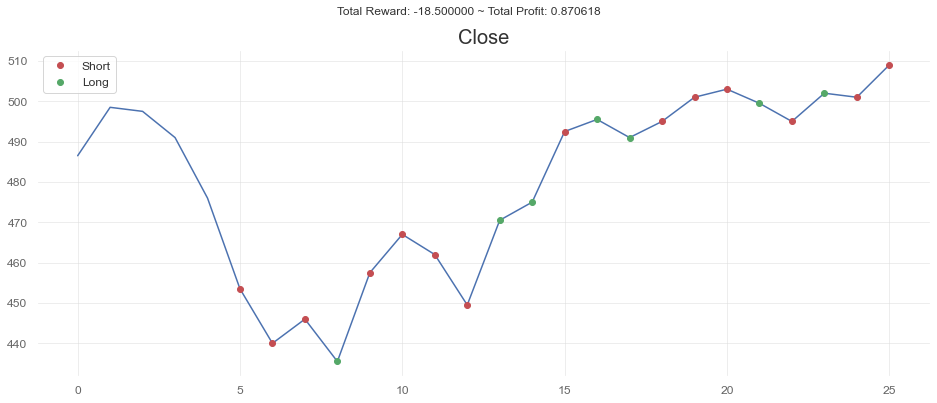

In [13]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓


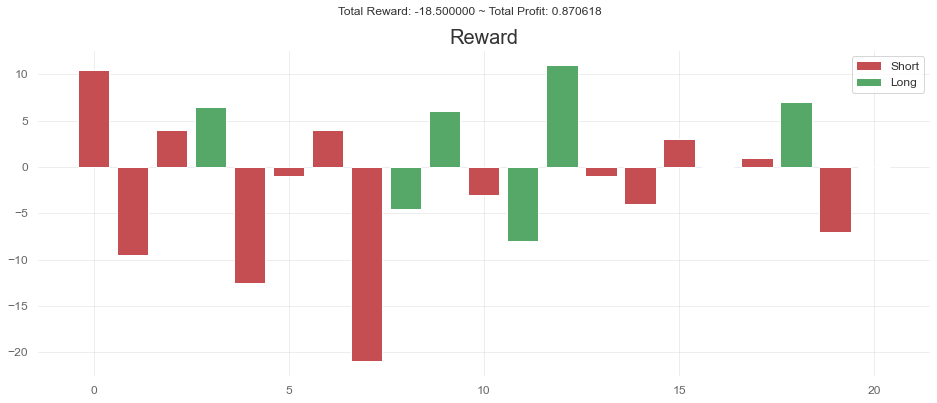

In [14]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


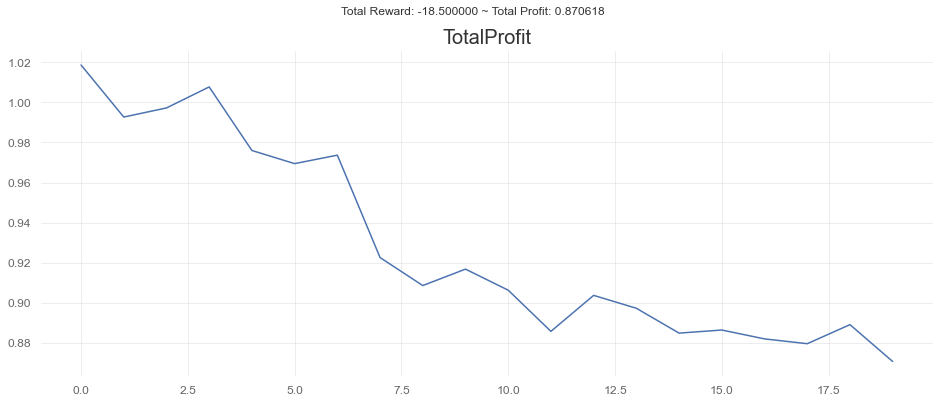

In [15]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [1]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)